In [5]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
def euclideanDistance(point1, point2):
    return np.linalg.norm(point1 - point2)

def getNeighbors(data, pointIdx, eps):
    dists = np.linalg.norm(data - data[pointIdx], axis=1)
    return np.where(dists <= eps)[0]

In [7]:
from scipy.spatial.distance import cdist

class DBScan:
    def __init__(self, eps, minPts):
        self.eps = eps
        self.minPts = minPts
        self.labels = None

    def getNeighbors(self, pointIdx):
        return np.where(self.distMatrix[pointIdx] <= self.eps)[0]

    def expandCluster(self, pointIdx, neighbors, clusterId, distMatrix, visited):
        self.labels[pointIdx] = clusterId
        visited[pointIdx] = True
        queue = deque(neighbors[~visited[neighbors]])

        while queue:
            currentIdx = queue.popleft()
            visited[currentIdx] = True

            if self.labels[currentIdx] == -1:
                self.labels[currentIdx] = clusterId

            currentNeighbors = self.getNeighbors(currentIdx)

            if len(currentNeighbors) >= self.minPts:
                mask = (~visited[currentNeighbors]) & (self.labels[currentNeighbors] == -1)
                queue.extend(currentNeighbors[mask])

    def findOptimalEps(self, data, plot=False):
        distances = cdist(data, data)
        kDistances = np.sort(distances, axis=1)[:, self.minPts]
        kDistances = np.sort(kDistances)

        x = np.arange(len(kDistances))
        xNorm = (x - x[0]) / (x[-1] - x[0] + 1e-10)
        yNorm = (kDistances - kDistances[0]) / (kDistances[-1] - kDistances[0] + 1e-10)

        diff1 = np.diff(yNorm) / np.diff(xNorm)
        diff2 = np.diff(diff1)

        elbowIdx = np.argmax(diff2) + 2
        optimalEps = kDistances[elbowIdx]

        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(kDistances)
            plt.axhline(y=optimalEps, color='r', linestyle='--', label=f'Optimal eps={optimalEps:.3f}')
            plt.axvline(x=elbowIdx, color='g', linestyle='--', alpha=0.5)
            plt.xlabel('Points sorted by k-distance')
            plt.ylabel(f'{self.minPts}-NN Distance')
            plt.title('K-distance Graph for Eps Selection')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

        self.eps = optimalEps
        return optimalEps

    def fit(self, data):
        self.distMatrix = np.linalg.norm(data[:, None] - data[None, :], axis=-1)
        n = data.shape[0]
        self.labels = np.full(n, -1)

        clusterId = 0
        visited = np.full(n, False)

        for i in range(n):
            if visited[i]:
                continue
            visited[i] = True

            neighbors = self.getNeighbors(i)

            if len(neighbors) < self.minPts:
                self.labels[i] = -1
            else:
                clusterId += 1
                self.expandCluster(i, neighbors, clusterId, self.distMatrix, visited)

        return self


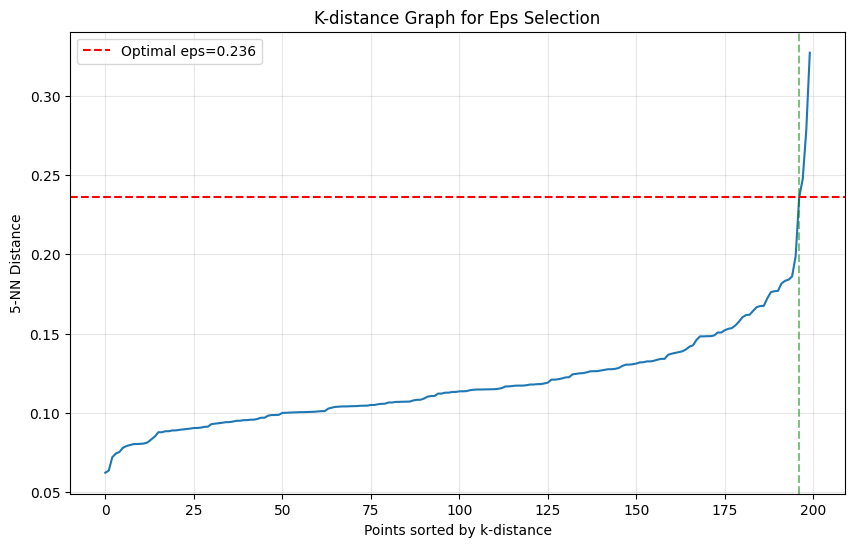

Optimal eps: 0.236


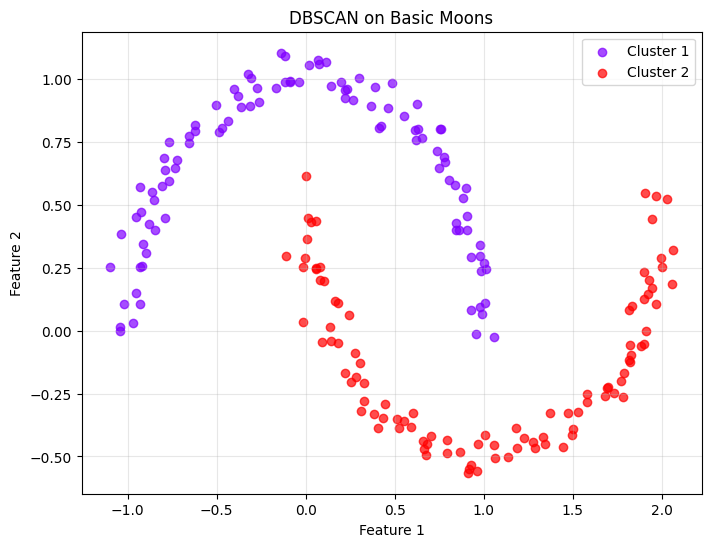

In [8]:
from sklearn.datasets import make_moons

# Generate basic moons data
data, _ = make_moons(n_samples=200, noise=0.05, random_state=42)

# Run DBScan with auto eps
dbscan = DBScan(eps=None, minPts=5)
optimal_eps = dbscan.findOptimalEps(data, plot=True)
dbscan.fit(data)
print(f"Optimal eps: {optimal_eps:.3f}")

# Plot clusters
unique_labels = np.unique(dbscan.labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    mask = dbscan.labels == label
    color = colors[i] if label != -1 else 'gray'  # Gray for noise
    plt.scatter(data[mask, 0], data[mask, 1], c=[color], label=f'Cluster {label}' if label != -1 else 'Noise', alpha=0.7)

plt.title('DBSCAN on Basic Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()